In [ ]:
#@title Доступные ресурсы
import multiprocessing
import torch
from psutil import virtual_memory

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

!nvidia-smi

In [1]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
if info.total>16252636672:
  print('Everything is ok, you can begin')
else:
  print('We dont recomend to begin, you gonna get Out of memory')

Everything is ok, you can begin


# Install all we need

In [ ]:
!pip install rudalle==0.0.1rc4

In [ ]:
!pip install wandb
!wandb login

# data to dataloader

## We  gonna generate some sneakers

In [ ]:
#@markdown Lets download data
!gdown https://drive.google.com/uc?id=1p4xwKEDHPhm18zBS_pMVJ1mp2Y5CE1a8
!gdown https://drive.google.com/uc?id=1iSDbibP-o9gIk9YzpmI-Y_h_uWPqxTZh
!unzip sneaksa.zip

In [ ]:
#@markdown import model
from rudalle.pipelines import generate_images, show, super_resolution, cherry_pick_by_clip
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_realesrgan, get_ruclip
from rudalle.utils import seed_everything




device = 'cuda'
model = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)
vae = get_vae().to(device)
tokenizer = get_tokenizer()

In [ ]:
#@markdown Data preparation
import io
import os
import PIL
import random
import numpy as np
import torch
import torchvision
import transformers
import more_itertools
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from torch.utils.data import Dataset
from tqdm import tqdm
from dataclasses import dataclass, field
import torchvision.transforms as T
import torchvision.transforms.functional as TF


class RuDalleDataset(Dataset):
    clip_filter_thr = 0.24
    def __init__(
            self,
            file_path,
            csv_path,
            tokenizer,
            resize_ratio=0.75,
            shuffle=True,
            load_first=None,
            caption_score_thr=0.6
    ):
        """ tokenizer - объект с методами tokenizer_wrapper.BaseTokenizerWrapper """
       
        self.text_seq_length = model.get_param('text_seq_length')
        self.tokenizer = tokenizer
        self.target_image_size = 256
        self.image_size=256
        self.samples = []


        self.image_transform = T.Compose([
                T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
                T.RandomResizedCrop(self.image_size,
                                    scale=(1., 1.), # в train было scale=(0.75., 1.),
                                    ratio=(1., 1.)),
                T.ToTensor()
            ])
        
        df = pd.read_csv(csv_path)
        for caption, f_path  in zip(df['caption'], df['name']):
            if len(caption)>10 and len(caption)<100 and os.path.isfile(f'{file_path}/{f_path}'):

              self.samples.append([file_path, f_path, caption])
        if shuffle:
            np.random.shuffle(self.samples)
            print('Shuffled')
    
    def __len__(self):
        return len(self.samples)

    def load_image(self, file_path, img_name):
        image = PIL.Image.open(f'{file_path}/{img_name}')
        return image

    def __getitem__(self, item):
        item = item % len(self.samples)  # infinite loop, modulo dataset size
        file_path, img_name, text = self.samples[item]
        try:
          image = self.load_image(file_path, img_name)
          image = self.image_transform(image).to(device)
        except Exception as err:  # noqa
            print(err)
            random_item = random.randint(0, len(self.samples) - 1)
            return self.__getitem__(random_item)
        text =  tokenizer.encode_text(text, text_seq_length=self.text_seq_length).squeeze(0).to(device)
        return text, image

In [ ]:
class Args():
    def __init__(self):
     
        self.text_seq_length = model.get_param('text_seq_length')
        self.total_seq_length = model.get_param('total_seq_length')
        self.epochs = 1
        self.save_path='checkpoints/'
        self.model_name = 'awesomemodel_'
        self.save_every = 2000
        self.prefix_length = 10
        self.bs = 1
        self.clip = 0.24
        self.lr = 4e-5
        self.warmup_steps =50
        self.wandb = True
args = Args()
if not os.path.exists(args.save_path):
        os.makedirs(args.save_path)

#RuDalle Dataset class
##Simple dataset class where you pass .csv with 


filepath - name of dir where you store images

________________________

**name     |     caption**
________________________
*Image name* | *Caption*

In [ ]:
from torch.utils.data import Dataset, DataLoader
st = RuDalleDataset(file_path='content/sneaks/' ,csv_path ='data_desc.csv',tokenizer=tokenizer)
train_dataloader = DataLoader(st, batch_size=args.bs, shuffle=True, drop_last=True)

In [ ]:
#Setup logs
#import os
#os.environ["WANDB_START_METHOD"] = "thread"
try:
  import wandb
  wandb.init(project = args.model_name, entity = "alexwortega")#change it
  args.wandb = True
except:
  args.wandb = False

In [ ]:
from transformers import  AdamW, get_linear_schedule_with_warmup
model.train()
optimizer = AdamW(model.parameters(), lr = args.lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.lr, 
                                                final_div_factor=500,  
                                                steps_per_epoch=len(train_dataloader), epochs=args.epochs )




In [ ]:
def freeze(
    model,
    freeze_emb=True,
    freeze_ln=False,
    freeze_attn=False,
    freeze_ff=True,
    freeze_other=True,
):
    for name, p in model.module.named_parameters():
        name = name.lower()
        if 'ln' in name or 'norm' in name:
            p.requires_grad = not freeze_ln
        elif 'embeddings' in name:
            p.requires_grad = not freeze_emb
        elif 'mlp' in name:
            p.requires_grad = not freeze_ff
        elif 'attn' in name:
            p.requires_grad = not freeze_attn
        else:
            p.requires_grad = not freeze_other
    return model

In [ ]:
#markdown Simple training loop
def train(model,args: Args, train_dataloader: RuDalleDataset):
  
  
  """
  args - arguments for training

  train_dataloader - RuDalleDataset class with text - image pair in batch
  """
  loss_logs = []
  try:
    progress = tqdm(total=len(train_dataloader), desc='finetuning goes brrr')
    save_counter = 0
    for epoch in range(args.epochs):
      
      for text, images in train_dataloader:
        device = model.get_param('device')
        save_counter+=1
        model.zero_grad()
        attention_mask = torch.tril(torch.ones((args.bs, 1, args.total_seq_length, args.total_seq_length), device=device))
        image_input_ids = vae.get_codebook_indices(images)
        
        input_ids = torch.cat((text, image_input_ids), dim=1) 
        loss, loss_values = model.forward(input_ids, attention_mask, return_loss=True)
        #train step
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(),args.clip)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        #save every here
        if save_counter % args.save_every == 0:
          print(f'Saveing checkpoint here {args.model_name}_dalle_{save_counter}.pt')
          
          plt.plot(loss_logs)
          plt.show()
          torch.save(
                    model.state_dict(),
                    os.path.join(args.save_path,f"{args.model_name}_dalle_{save_counter}.pt")
                    )
        if args.wandb:
          wandb.log({"loss":  loss.item()})
        loss_logs+=[loss.item()]
        progress.update()
        progress.set_postfix({"loss": loss.item()})
    
    print(f'Complitly tuned and saved here  {args.model_name}__dalle_last.pt')
    
    plt.plot(loss_logs)
    plt.show()
    
    torch.save(
                model.state_dict(),
                os.path.join(args.save_path,f"{args.checkpoints}/{args.model_name}_dalle_last.pt")
                )
  
  except KeyboardInterrupt:
    
    
    print(f'What for did you stopped? Please change model_path to /{args.checkpoints}/{args.model_name}_dalle_Failed_train.pt')
    plt.plot(loss_logs)
    plt.show()
    
    torch.save(
                model.state_dict(),
                os.path.join(args.save_path,f"{args.checkpoints}/{args.model_name}_dalle_Failed_train.pt")
                )
  except Exception as err:
    print(f'Failed with {err}')

In [ ]:
#@markdown You can unfreeze or freeze more parametrs, but it can 
model = freeze(model = model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=False)#freeze params to 

train(model, args, train_dataloader)

# Lets generate

In [ ]:
#load model 
model_path = os.path.join('/content/'+args.save_path,f"{args.model_name}_dalle_last.pt")
model = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)
model.load_state_dict(torch.load(model_path)) 
print(f'Loaded from {model_path}')
vae = get_vae().to(device)

100%|██████████| 1024/1024 [01:28<00:00, 11.52it/s]


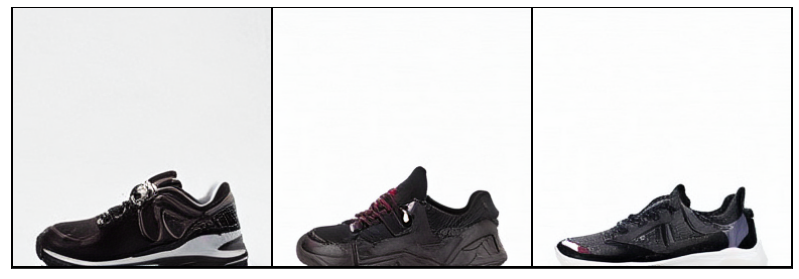

In [ ]:
pil_images = []
scores = []
text = 'Кроссовки, Nike, цвет: черный'

for top_k, top_p, images_num in [(2048, 0.995, 3)]:
    _pil_images, _scores = generate_images(text, tokenizer, model, vae, top_k=top_k, images_num=images_num, top_p=top_p)
    pil_images += _pil_images
show([pil_image for pil_image in pil_images], 3)

100%|██████████| 1024/1024 [01:04<00:00, 15.79it/s]


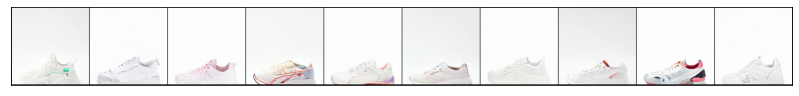

In [ ]:
pil_images = []
scores = []
text = 'Кроссовки, Adidas superstar, цвет: белый'

for top_k, top_p, images_num in [(2048, 0.995, 10)]:
    _pil_images, _scores = generate_images(text, tokenizer, model, vae, top_k=top_k, images_num=images_num, top_p=top_p)
    pil_images += _pil_images
show([pil_image for pil_image in pil_images], 10)

# Compare results

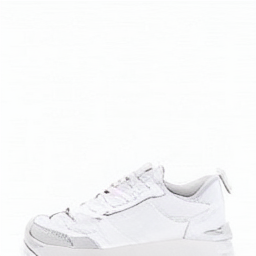

In [ ]:
pil_images[1]

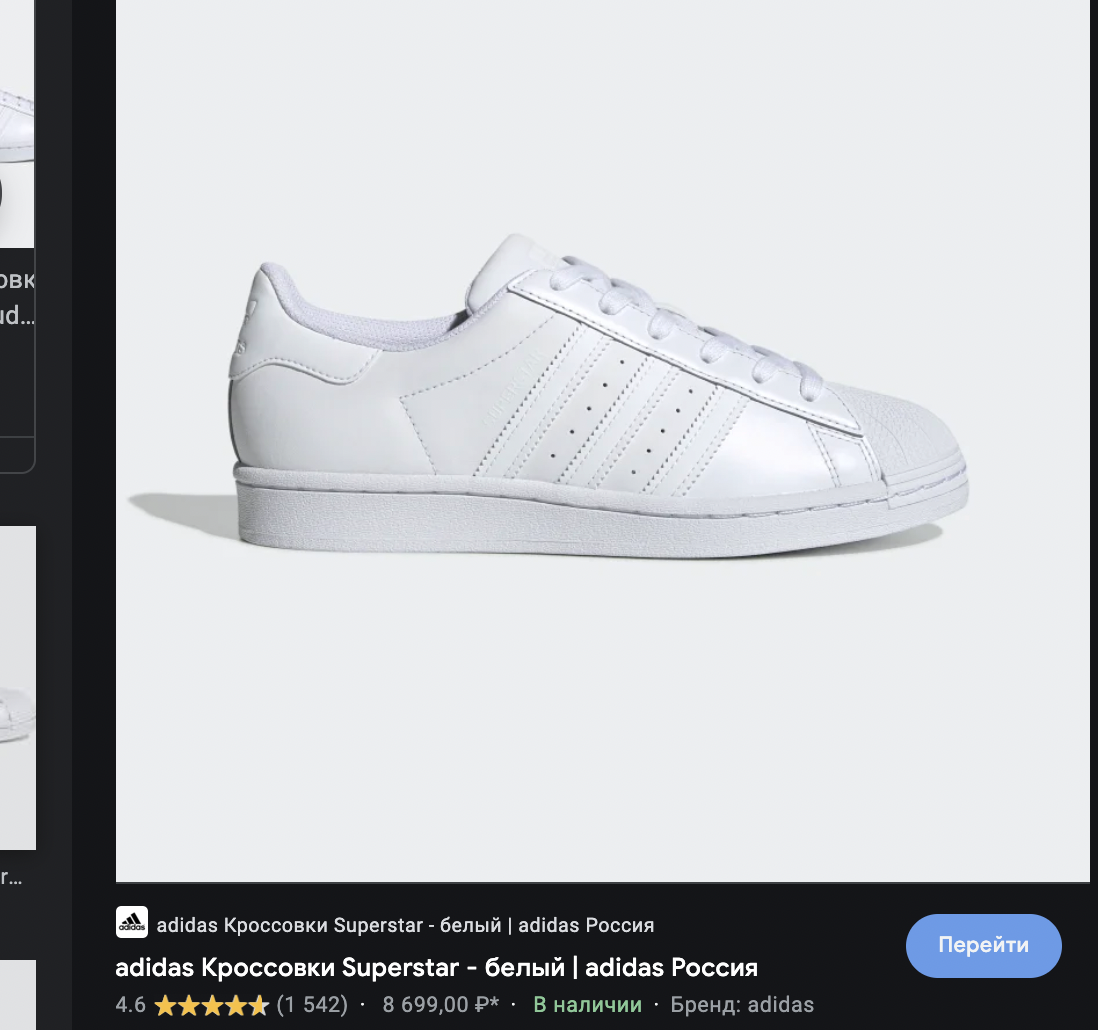